# Check_stat_test_result.ipynb

This file used for the development of `get_stats_test_result.py`

In [1]:
import numpy as np
import os
import scipy.stats as st
import sys
sys.path.append('..')
import functions.data_class as data_class
from functions.calc_stat_tests import normal
import functions.plot as plot
import importlib

In [2]:
%config InlineBackend.figure_format = 'png'

In [3]:
%%html
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>

In [4]:
# read output files.

data_path = '../statistic_test_result/fib_100'

tests = ['proj_test', 'mcf_slope_test', 'dgf_test']

# path for output plot.
out_path = os.path.join('../images/', os.path.split(data_path)[-1])

In [6]:
# for all test
n1, n2 = 13, 12
# for test 1
r1, r2 = 5, 6

# Observational data
# for test 2.
# from "../observations/read_observation.ipynb"
mean_mcf_planck, std_mcf_planck = \
    0.30980160604629208843, 0.10110408944998323932
mean_mcf_optical, std_mcf_optical = \
    0.25598335067637884022, 0.11532147170719482532

# for test 3.
# from "../observations/read_observation.ipynb"
mean_dgf_planck, std_dgf_planck = \
    -0.84625749795768490102, 0.27082182081083627789
mean_dgf_optical, std_dgf_optical = \
    -0.72734920072607889274, 0.27451288585330863024
    

# number of parallel cloud (k)
k1 = np.arange(n1+1)
k2 = np.arange(n2+1)

# Test 1 - Projection test.

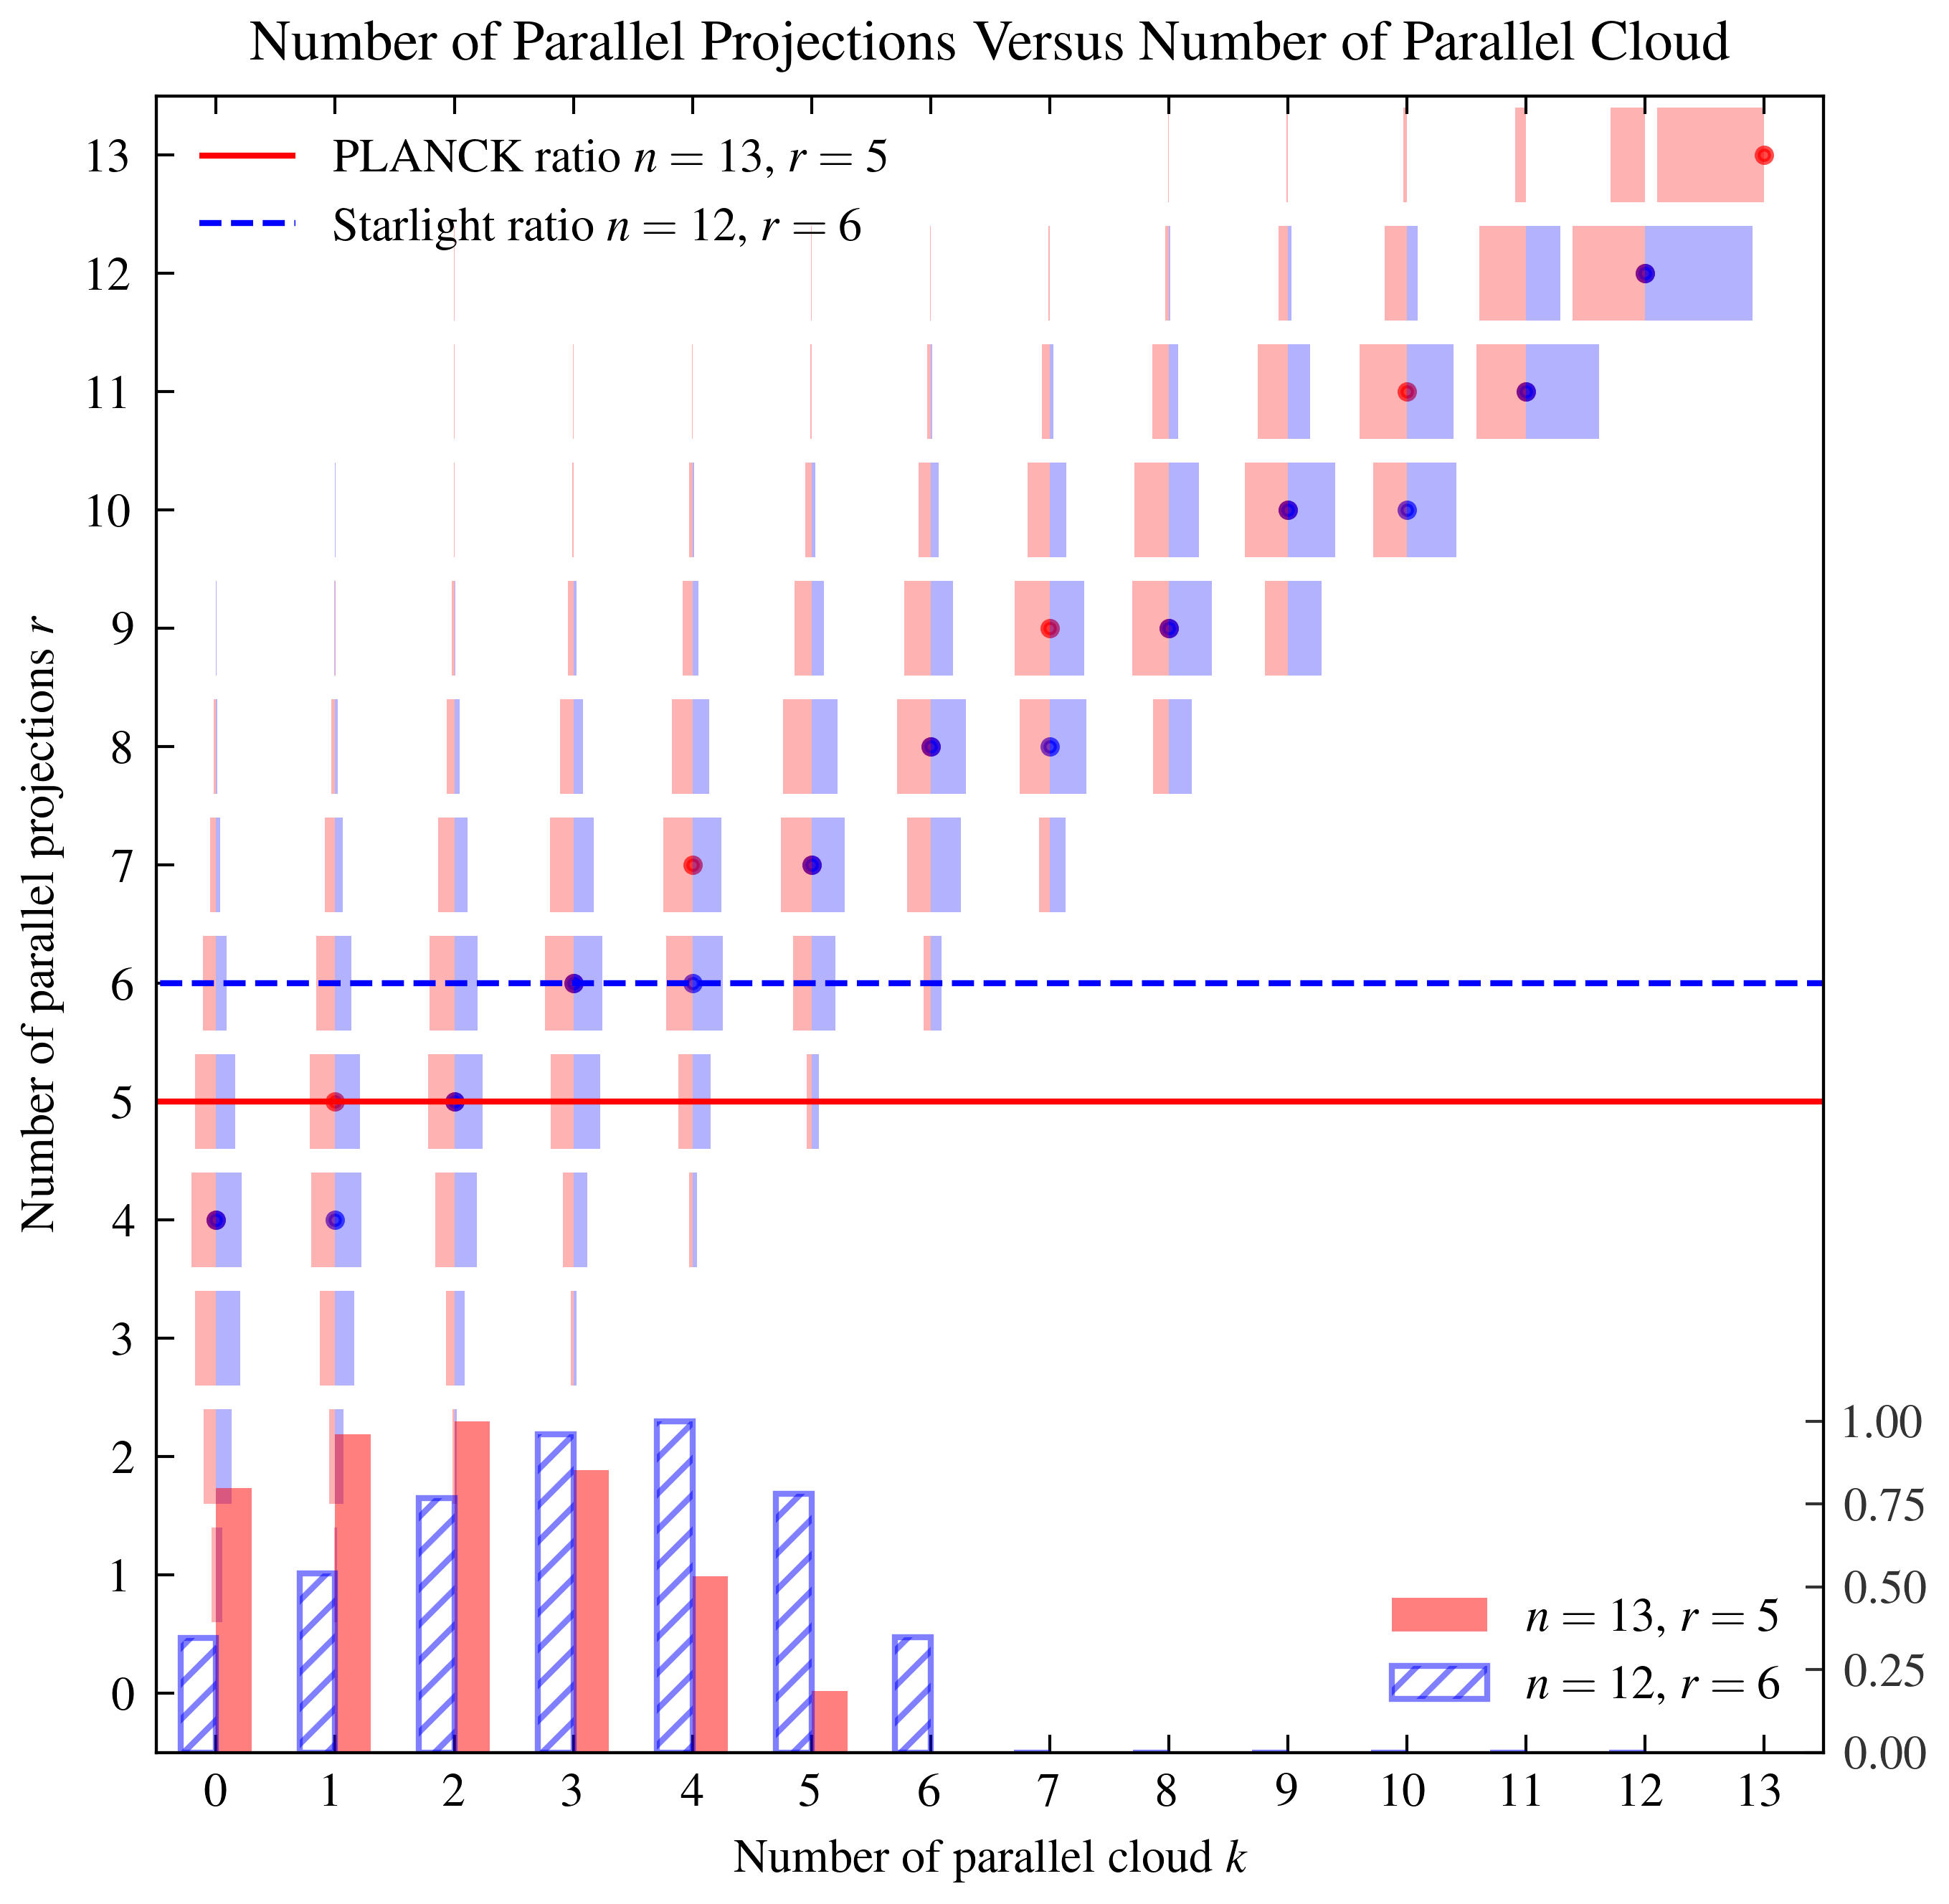

In [7]:
# file path and output path
proj_file_1 = f"{tests[0]}_{n1}.h5"  # file for planck's data
proj_file_2 = f"{tests[0]}_{n2}.h5"  # file for optical data.
out_file = f"{tests[0]}.png"

# Read data
proj_1 = data_class.read_data(os.path.join(data_path, proj_file_1))
proj_2 = data_class.read_data(os.path.join(data_path, proj_file_2))

# maximum likelihood estimation of number of parallel projection r for different k
mle_proj_1 = np.array([k1[likeli.argmax()]
                        for likeli in proj_1['probability']])
mle_proj_2 = np.array([k2[likeli.argmax()]
                        for likeli in proj_2['probability']])

# Relative Likelihood function for observing r.
likeli_proj_1 = proj_1['probability'][:, r1] / \
    proj_1['probability'][:, r1].max()
likeli_proj_2 = proj_2['probability'][:, r2] / \
    proj_2['probability'][:, r2].max()

# TODO plot the output.
plot.plot_statistic_test_discrete(
    x1=k1, y1=mle_proj_1, li1=likeli_proj_1, bar_coord1=k1,
    prob1=proj_1['probability'], obs1=r1,
    x2=k2, y2=mle_proj_2, li2=likeli_proj_2, bar_coord2=k2,
    prob2=proj_2['probability'], obs2=r2,
    xlim=(-0.5, 13.5), ylim=(-0.5, 13.5), bottom_scale=0.2,
    xlabel='Number of parallel cloud $k$', ylabel="Number of parallel projections $r$",
    title=f"Number of Parallel Projections Versus Number of Parallel Cloud",
    likeli_label1=f"$n={n1}$, $r={r1}$", likeli_label2=f"$n={n2}$, $r={r2}$",
    obs_label1=f"PLANCK ratio $n={n1}$, $r={r1}$",
    obs_label2=f"Starlight ratio $n={n2}$, $r={r2}$",
)

# Test 2 - MCF Slope test

In [8]:
# file path and output path
mcf_slope_file_1 = f"{tests[1]}_{n1}.h5"  # file for planck's data
mcf_slope_file_2 = f"{tests[1]}_{n2}.h5"  # file for optical data.
out_file = f"{tests[1]}.png"

# Read data
mcf_slope_1 = data_class.read_data(
    os.path.join(data_path, mcf_slope_file_1))
mcf_slope_2 = data_class.read_data(
    os.path.join(data_path, mcf_slope_file_2))

# mean mcf slope different for each k
mean_mcf_slope_1 = np.array([np.nanmean(samples) if any(~np.isnan(samples)) else np.nan
                            for samples in mcf_slope_1['result']])
mean_mcf_slope_2 = np.array([np.nanmean(samples) if any(~np.isnan(samples)) else np.nan
                            for samples in mcf_slope_2['result']])

# KDE of mcf slope different for each k
kde_mcf_slope_1 = [st.gaussian_kde(samples[~np.isnan(samples)]) if any(~np.isnan(samples)) else None
                    for samples in mcf_slope_1['result']]
kde_mcf_slope_2 = [st.gaussian_kde(samples[~np.isnan(samples)]) if any(~np.isnan(samples)) else None
                    for samples in mcf_slope_2['result']]

# mcf_slope dimensions
mcf_bar = np.linspace(-0.8, 0.92, 2000)

# observed distribution
den_obs_mcf1 = normal(mcf_bar, mean_mcf_planck, std_mcf_planck)
den_obs_mcf2 = normal(mcf_bar, mean_mcf_optical, std_mcf_optical)

# calculate fraction of valid sample
valid1 = np.array([np.sum(np.logical_and(samples > 0, samples < n1))/samples.size
                    for samples in mcf_slope_1['n_para']])
valid2 = np.array([np.sum(np.logical_and(samples > 0, samples < n2))/samples.size
                    for samples in mcf_slope_2['n_para']])

# probability distribution of mcf slope for different k.
den_mcf1 = [kde.pdf(mcf_bar)*total_prob if total_prob > 0 else np.empty(mcf_bar.size)*np.nan
            for kde, total_prob in zip(kde_mcf_slope_1, valid1)]
den_mcf2 = [kde.pdf(mcf_bar)*total_prob if total_prob > 0 else np.empty(mcf_bar.size)*np.nan
            for kde, total_prob in zip(kde_mcf_slope_2, valid2)]

# Relative Likelihood function for observing r,
# Intersection of two distribution
likeli_mcf_1 = np.array([np.nansum(den*den_obs_mcf1)
                            for den in den_mcf1])
likeli_mcf_2 = np.array([np.nansum(den*den_obs_mcf2)
                            for den in den_mcf2])
likeli_mcf_1 /= likeli_mcf_1.max()
likeli_mcf_2 /= likeli_mcf_2.max()

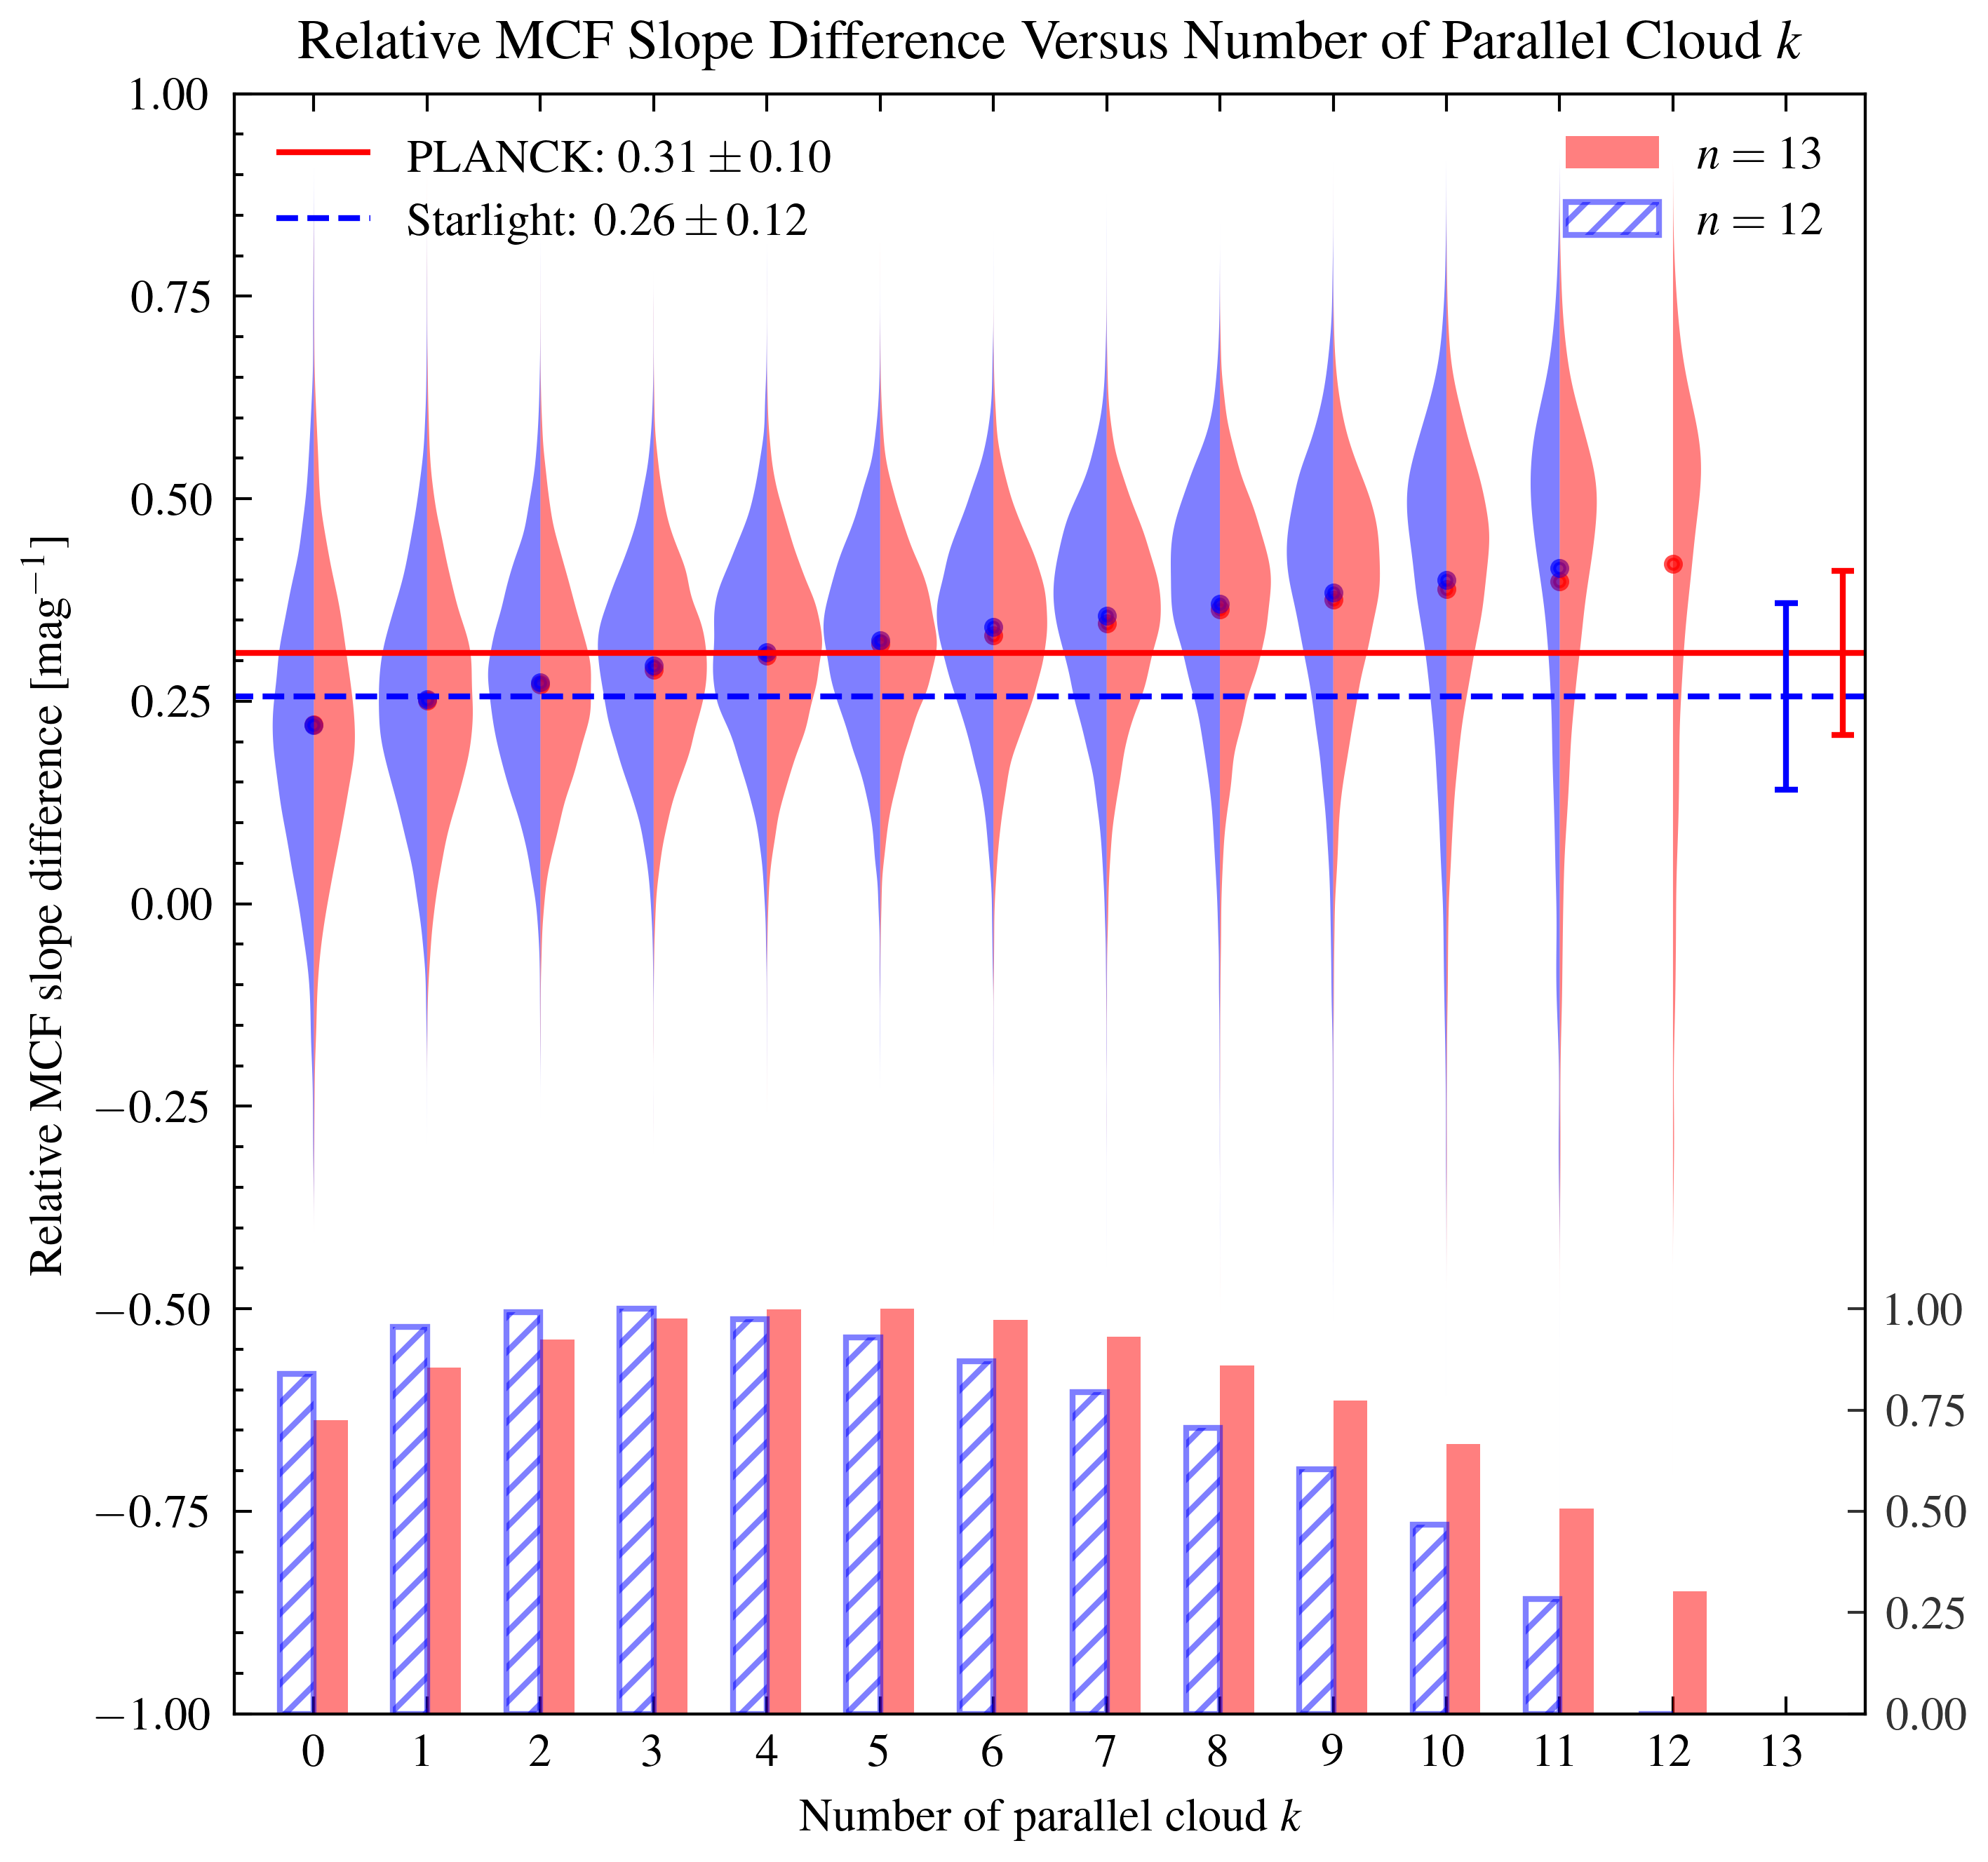

In [9]:
# TODO plot the output.
plot.plot_statistic_test_continues(
    x1=k1, y1=mean_mcf_slope_1, li1=likeli_mcf_1, bar_coord1=mcf_bar,
    prob1=den_mcf1, obs1=mean_mcf_planck,
    x2=k2, y2=mean_mcf_slope_2, li2=likeli_mcf_2, bar_coord2=mcf_bar,
    prob2=den_mcf2, obs2=mean_mcf_optical,
    xlim=(-.7, 13.7), ylim=(-1, 1), bottom_scale=0.25,
    obs1_std=std_mcf_planck, obs2_std=std_mcf_optical,
    vert_height=0.5,
    xlabel='Number of parallel cloud $k$',
    ylabel="Relative MCF slope difference [mag$^{-1}$]",
    title="Relative MCF Slope Difference Versus Number of Parallel Cloud $k$",
    obs_label1=f"PLANCK: ${mean_mcf_planck:.2f} \pm {std_mcf_planck:.2f}$",
    obs_label2=f"Starlight: ${mean_mcf_optical:.2f} \pm {std_mcf_optical:.2f}$",
    likeli_label1=f"$n={n1}$", likeli_label2=f"$n={n2}$",
)

# Test 3 - DGF test

In [10]:
# file path and output path
dgf_slope_file_1 = f"{tests[2]}_{n1}.h5"  # file for planck's data
dgf_slope_file_2 = f"{tests[2]}_{n2}.h5"  # file for optical data.
out_file = f"{tests[2]}.png"

# Read data
dgf_1 = data_class.read_data(
    os.path.join(data_path, dgf_slope_file_1))
dgf_2 = data_class.read_data(
    os.path.join(data_path, dgf_slope_file_2))

# mean dgf different for each k
mean_dgf_1 = np.array([np.nanmean(samples) if any(~np.isnan(samples)) else np.nan
                        for samples in dgf_1['result']])
mean_dgf_2 = np.array([np.nanmean(samples) if any(~np.isnan(samples)) else np.nan
                        for samples in dgf_2['result']])

# KDE of dgf different for each k
kde_dgf_slope_1 = [st.gaussian_kde(samples[~np.isnan(samples)]) if any(~np.isnan(samples)) else None
                    for samples in dgf_1['result']]
kde_dgf_slope_2 = [st.gaussian_kde(samples[~np.isnan(samples)]) if any(~np.isnan(samples)) else None
                    for samples in dgf_2['result']]

# dgf dimensions
dgf_bar = np.linspace(-4, 2, 2000)

# observed distribution
den_obs_dgf1 = normal(dgf_bar, mean_dgf_planck, std_dgf_planck)
den_obs_dgf2 = normal(dgf_bar, mean_dgf_optical, std_dgf_optical)

# calculate fraction of valid sample
valid1 = np.array([np.sum(np.logical_and(samples > 0, samples < n1))/samples.size
                    for samples in dgf_1['n_para']])
valid2 = np.array([np.sum(np.logical_and(samples > 0, samples < n2))/samples.size
                    for samples in dgf_2['n_para']])

# probability distribution of dgf for different k.
den_dgf1 = [kde.pdf(dgf_bar)*total_prob if kde else np.empty(dgf_bar.size)*np.nan
            for kde, total_prob in zip(kde_dgf_slope_1, valid1)]
den_dgf2 = [kde.pdf(dgf_bar)*total_prob if kde else np.empty(dgf_bar.size)*np.nan
            for kde, total_prob in zip(kde_dgf_slope_2, valid2)]

# Relative Likelihood function for observing r,
# Intersection of two distribution
likeli_dgf_1 = np.array([np.nansum(den*den_obs_dgf1)
                            for den in den_dgf1])
likeli_dgf_2 = np.array([np.nansum(den*den_obs_dgf2)
                            for den in den_dgf2])
likeli_dgf_1 /= likeli_dgf_1.max()
likeli_dgf_2 /= likeli_dgf_2.max()

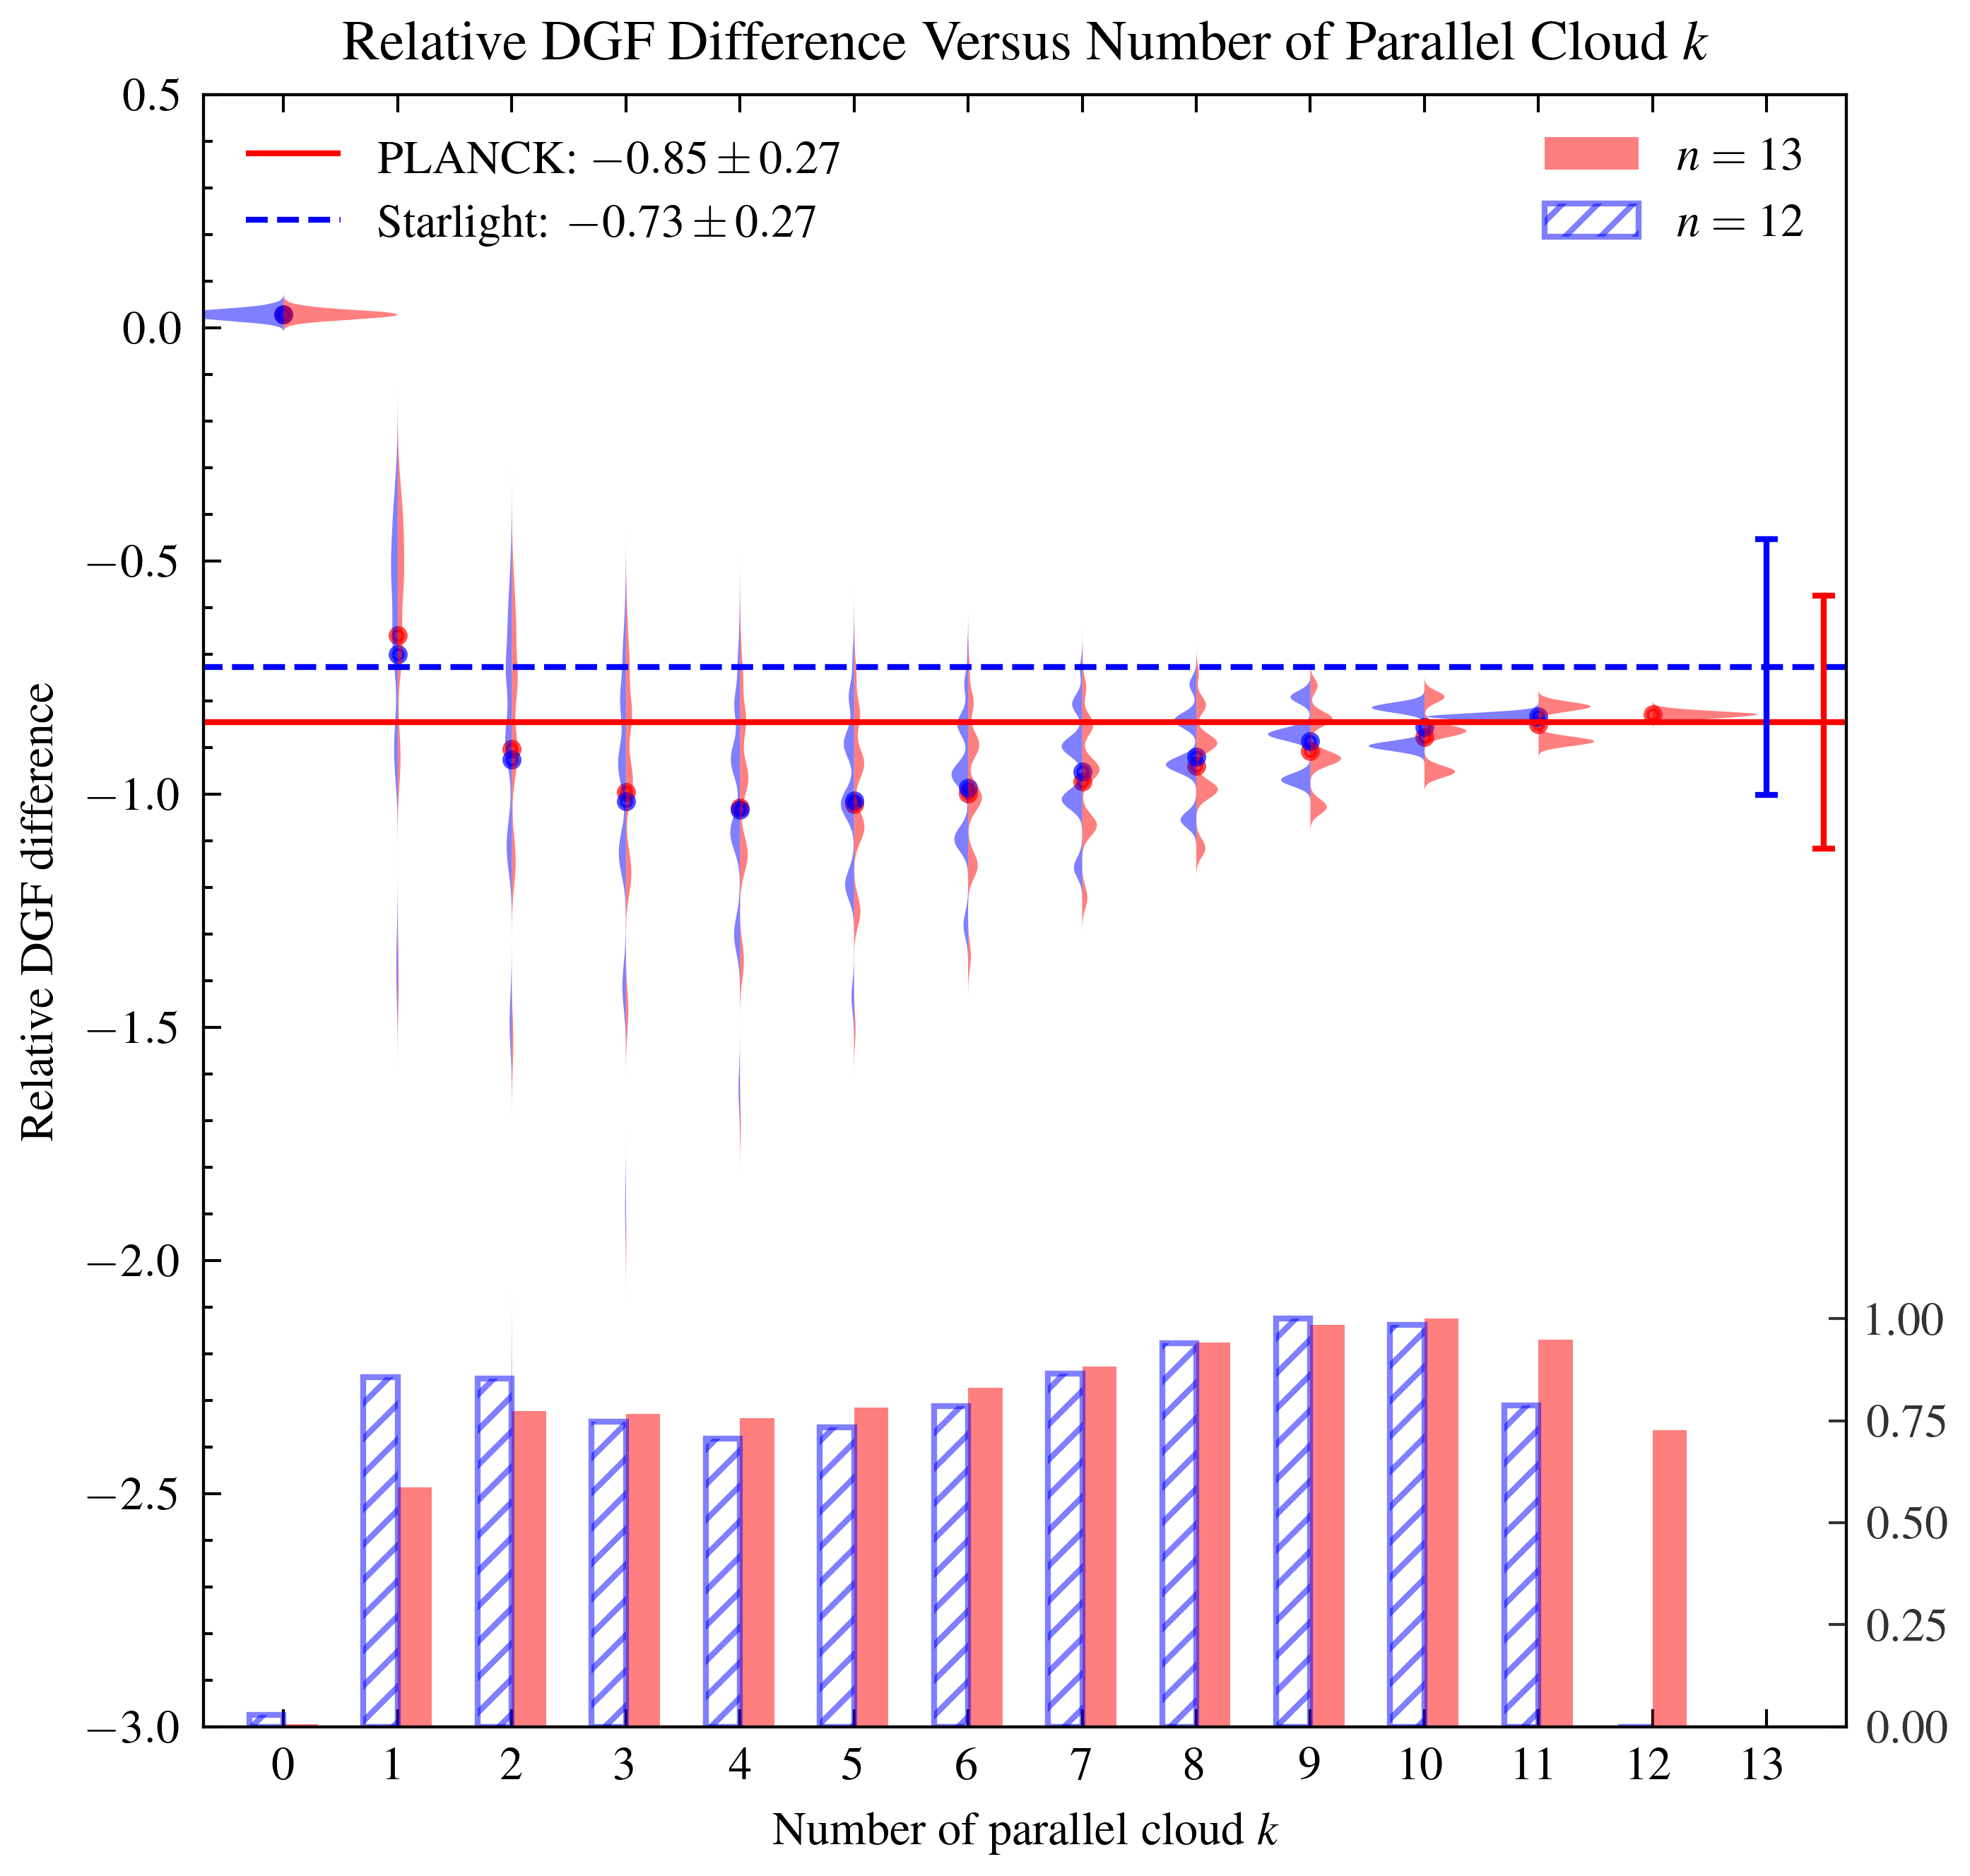

In [11]:
# TODO plot the output.
plot.plot_statistic_test_continues(
    x1=k1, y1=mean_dgf_1, li1=likeli_dgf_1, bar_coord1=dgf_bar,
    prob1=den_dgf1, obs1=mean_dgf_planck,
    x2=k2, y2=mean_dgf_2, li2=likeli_dgf_2, bar_coord2=dgf_bar,
    prob2=den_dgf2, obs2=mean_dgf_optical,
    xlim=(-.7, 13.7), ylim=(-3, 0.5), bottom_scale=0.25,
    obs1_std=std_dgf_planck, obs2_std=std_dgf_optical,
    vert_height=1,
    xlabel='Number of parallel cloud $k$',
    ylabel="Relative DGF difference",
    title="Relative DGF Difference Versus Number of Parallel Cloud $k$",
    obs_label1=f"PLANCK: ${mean_dgf_planck:.2f} \pm {std_dgf_planck:.2f}$",
    obs_label2=f"Starlight: ${mean_dgf_optical:.2f} \pm {std_dgf_optical:.2f}$",
    likeli_label1=f"$n={n1}$", likeli_label2=f"$n={n2}$",
    out_file=os.path.join(out_path, out_file)
)

# Total Likelihood

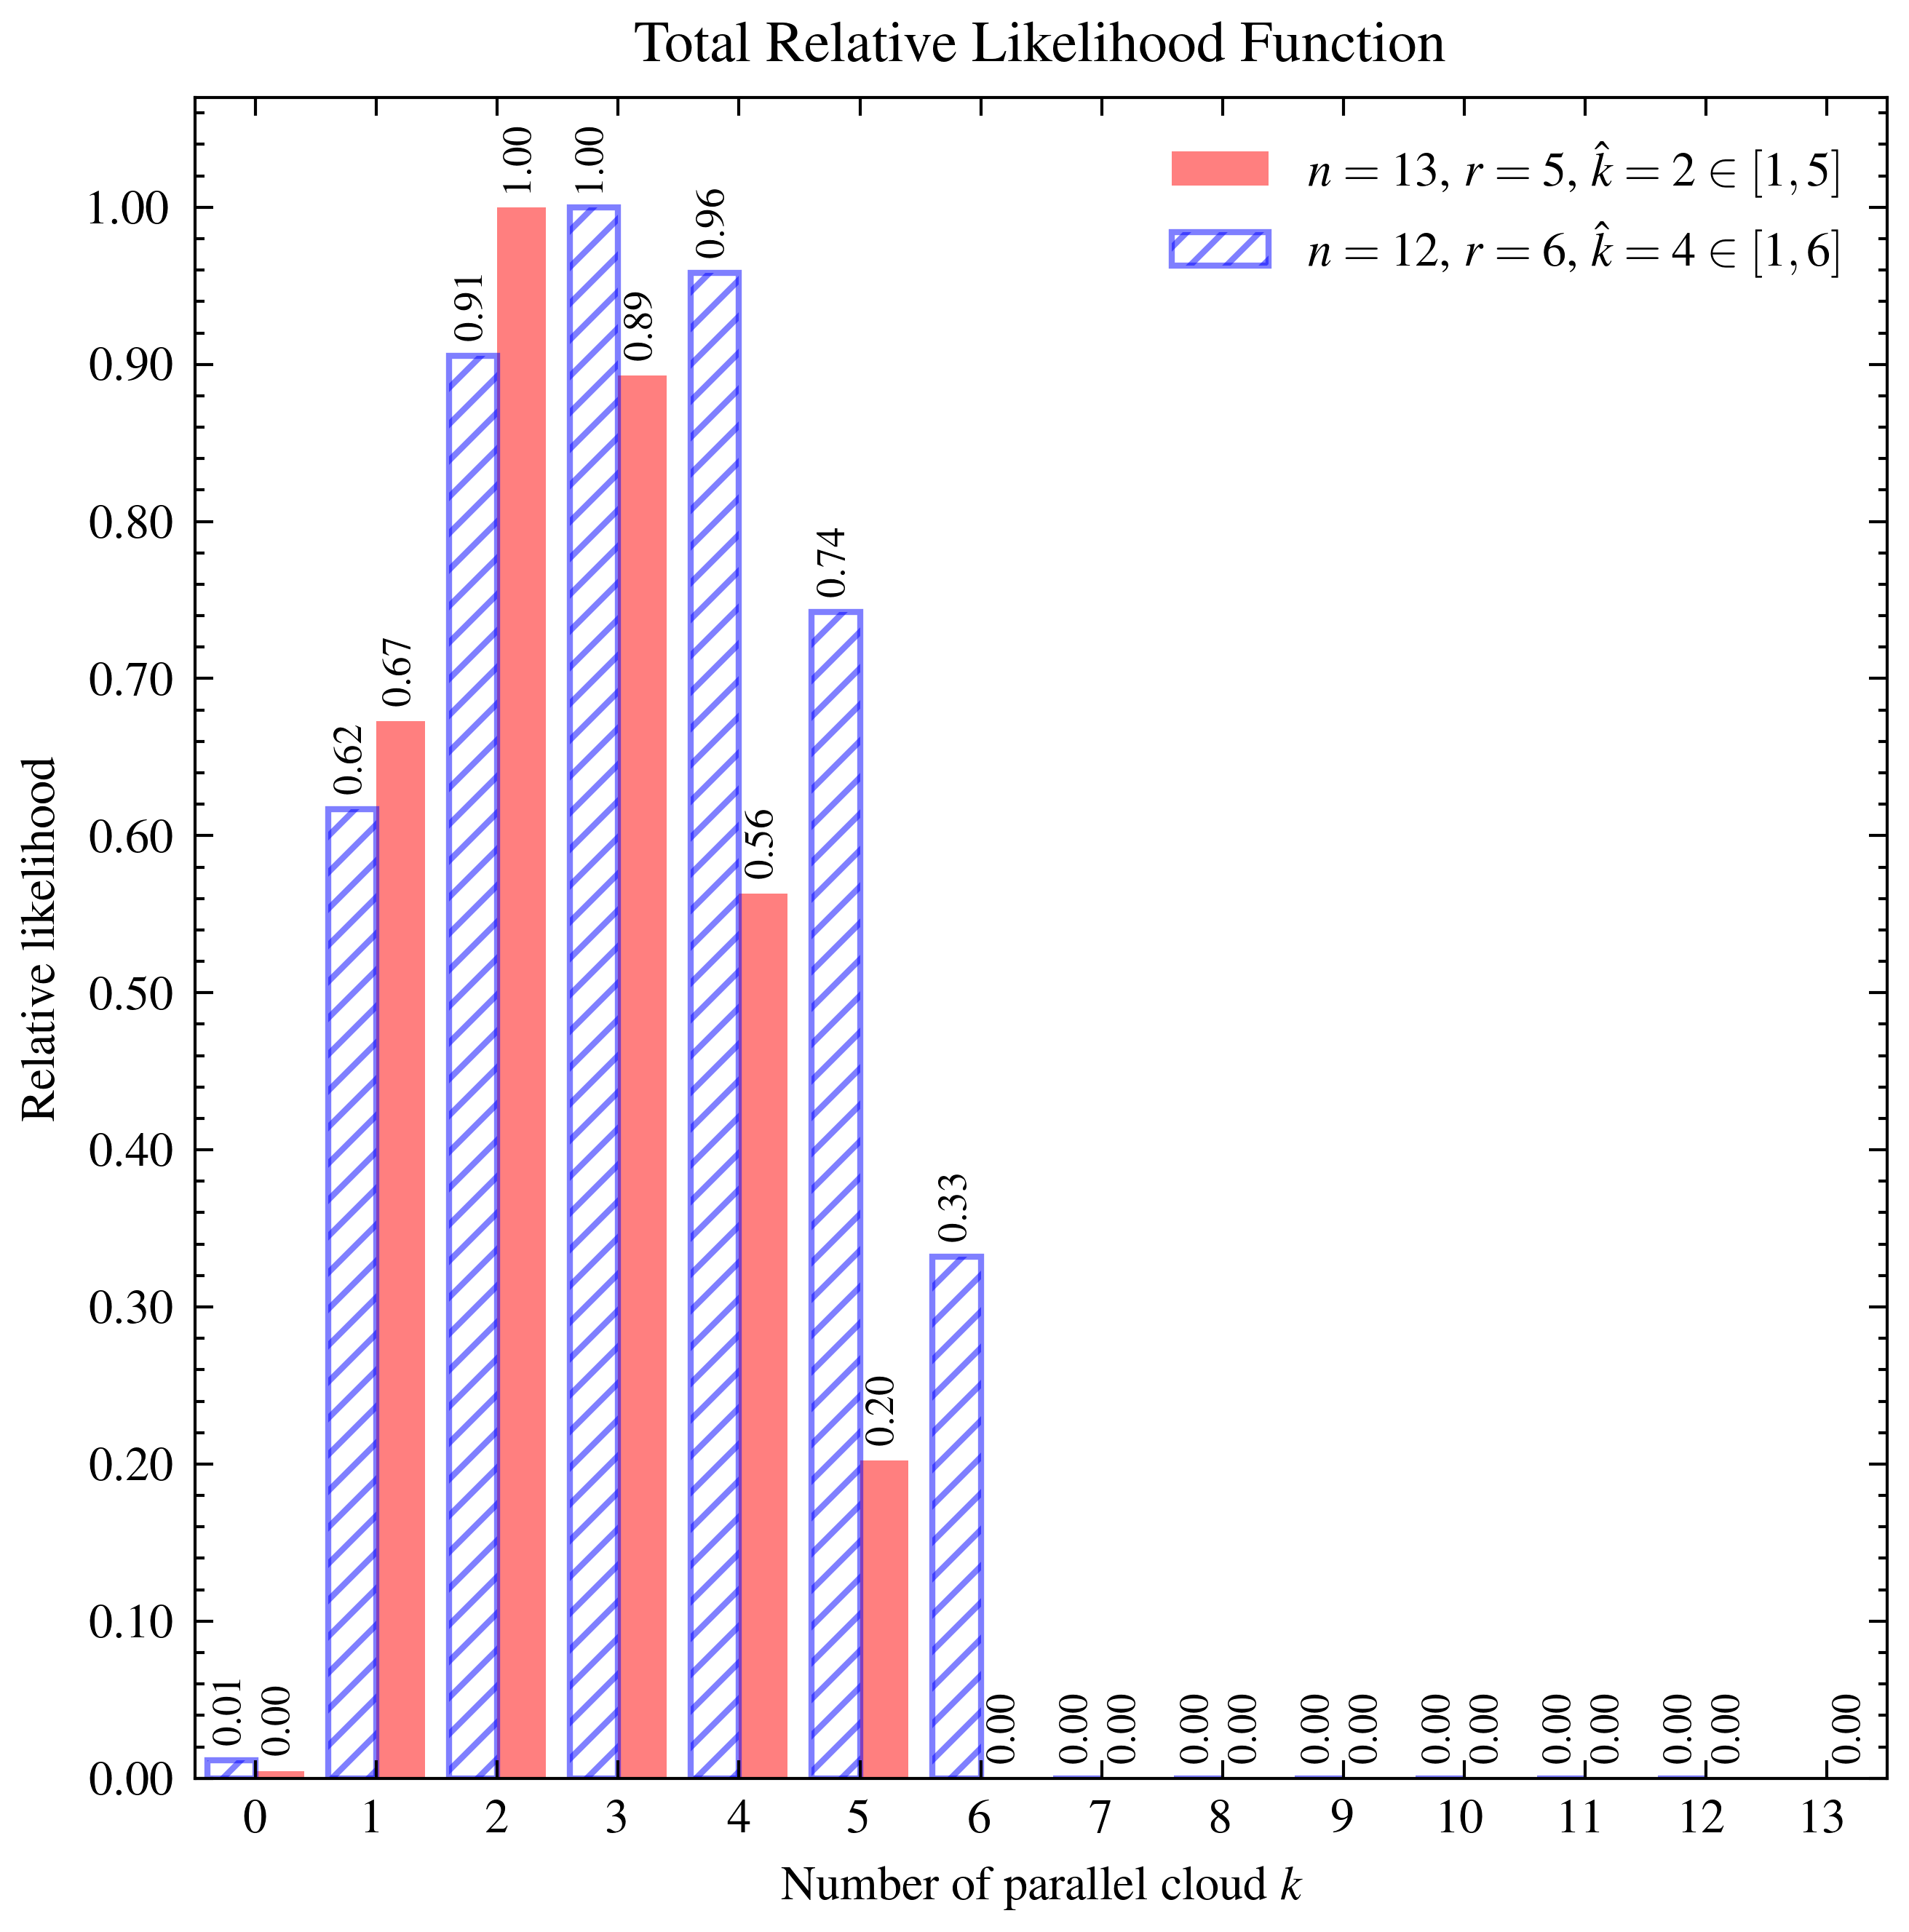

In [12]:
likeli_1 = likeli_proj_1*likeli_mcf_1*likeli_dgf_1
likeli_2 = likeli_proj_2*likeli_mcf_2*likeli_dgf_2

likeli_1 /= likeli_1.max()
likeli_2 /= likeli_2.max()

# TODO plot the output
plot.plot_likelihood(
    x1=k1, y1=likeli_1,
    x2=k2, y2=likeli_2,
    ylabel="Relative likelihood",
    xlabel="Number of parallel cloud $k$",
    title="Total Relative Likelihood Function",
    label1="$n=13$, $r=5$, $\hat{k}=2 \in[1,5]$",
    label2="$n=12$, $r=6$, $\hat{k}=4\in[1,6]$",
)

In [15]:
# calculate the p value
likeli_1/likeli_1.sum(), likeli_2/likeli_2.sum()

(array([0.00141204, 0.20168491, 0.29974981, 0.26766563, 0.16879911,
        0.06068851, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([0.00249487, 0.13508885, 0.19830387, 0.21899206, 0.20980952,
        0.16260605, 0.07270478, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]))